In [1]:
%load_ext autoreload
%autoreload 2

import os
from travel.constants import MODEL_CACHE_DIR
os.environ['HF_HOME'] = MODEL_CACHE_DIR

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [8]:
from travel.data.captaincook4d import CaptainCook4DDataset

PARTITION = "val"

# Load mistake detection dataset
dataset = CaptainCook4DDataset(data_split=PARTITION,
                               debug_n_examples_per_class=None)

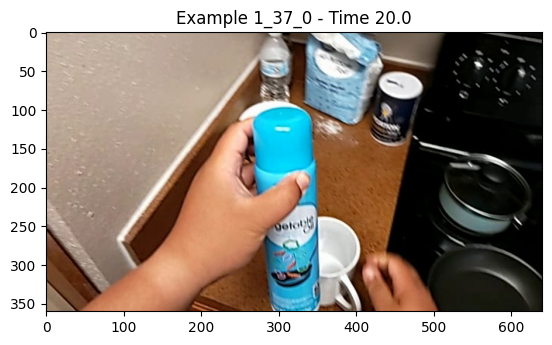

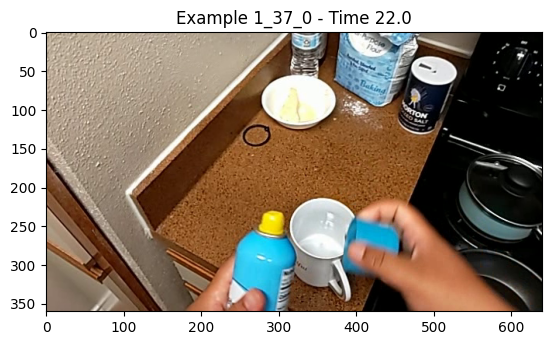

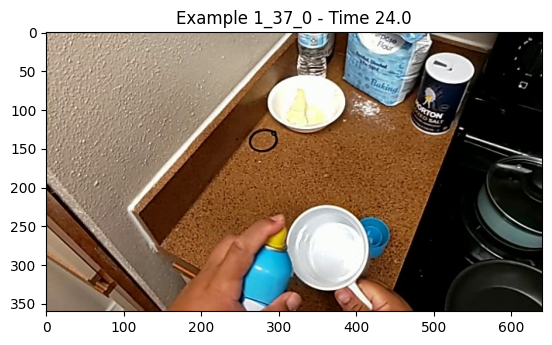

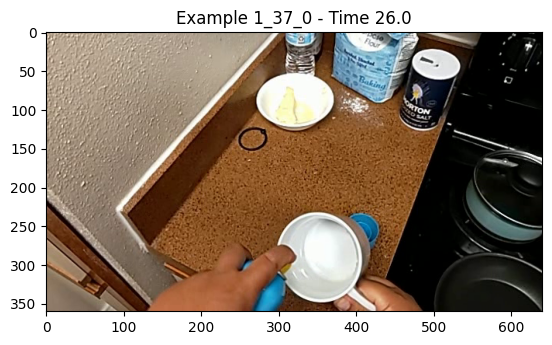

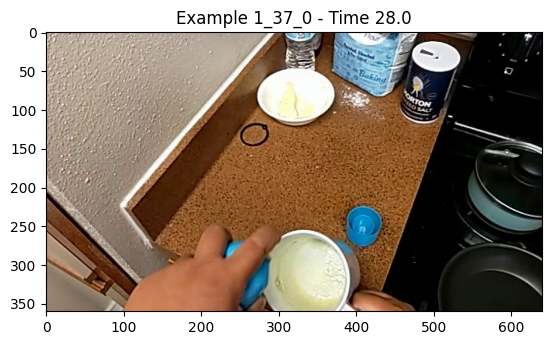

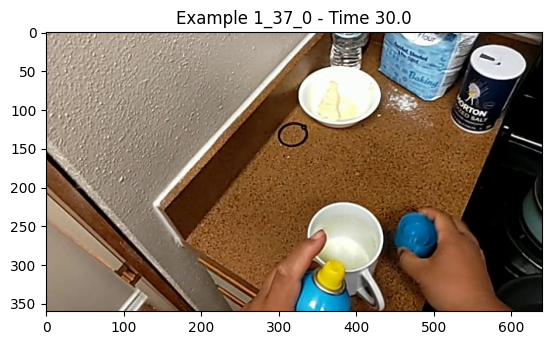

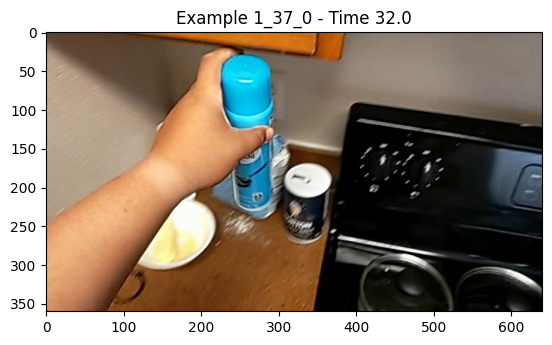

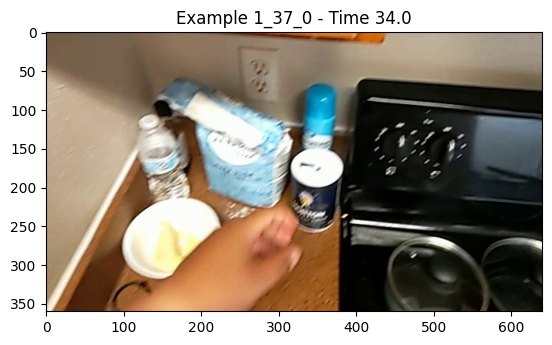

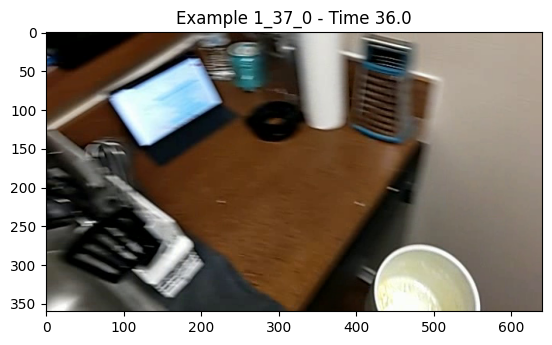

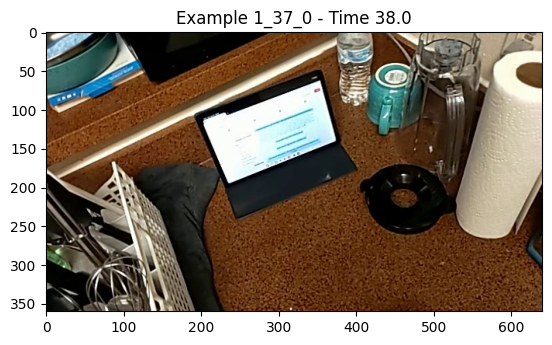

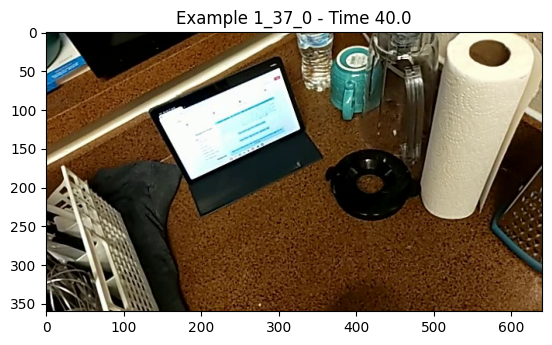

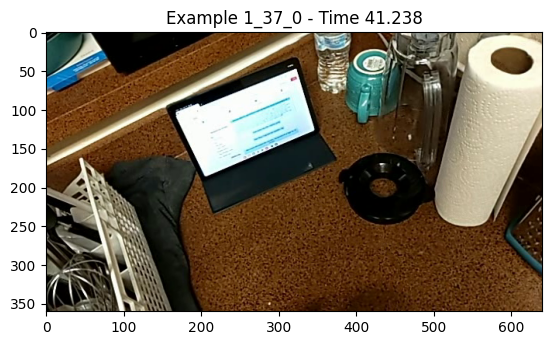

In [10]:
import matplotlib.pyplot as plt

RETRIEVE_ID = "1_37_0"
RETRIEVE_TIMES = [20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 41.238]

try:
    retrieve_example = [example for example in dataset if example.example_id == RETRIEVE_ID][0]
except:
    print(f"Could not find CaptainCook4D example {RETRIEVE_ID}.")
    raise

for time in RETRIEVE_TIMES:
    found_frame = False
    for frame, frame_time in zip(retrieve_example.frames, retrieve_example.frame_times):
        if round(frame_time, 1) == round(time, 1):
            found_frame = True
            plt.imshow(frame)
            plt.title(f"Example {retrieve_example.example_id} - Time {round(time,1)}")
            plt.show()
    if not found_frame:
        print(f"Could not find frame at time {time} in example {retrieve_example.example_id}.")